# Este notebook implementa o pipeline completo para adicionar dados textuais (notas clínicas) ao ED-Copilot.
 
**Pipeline:**
1. Carregar dados tabulares (já processados)
2. Carregar notas clínicas (discharge + radiology)
3. Pré-processar texto (limpeza, segmentação)
4. Filtro temporal (apenas notas disponíveis durante ED stay)
5. Integração texto + tabular
6. Criar splits train/val/test
7. Salvar dataset final

## 1. Setup

In [2]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Módulos customizados
from src.data.notes_loader import NotesLoader
from src.data.text_preprocessing import TextPreprocessor, TextConfig
from src.data.text_integration import (
    TextTabularIntegrator, FusionStrategy, 
    create_stratified_splits
)

# Configuração
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Imports concluídos")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
✓ Imports concluídos


## 2. Configurações

In [3]:
# Paths
DATA_ROOT = Path('../data/raw')
PROCESSED_ROOT = Path('../data/processed')
PROCESSED_ROOT.mkdir(exist_ok=True)

# Configuração de texto
text_config = TextConfig(
    max_tokens_per_segment=512,
    min_text_length=50,
    remove_special_chars=False,  # Preservar pontuação clínica
    lowercase=False  # Preservar case (importante em medicina)
)

# Estratégia de fusão
FUSION_STRATEGY = FusionStrategy.CONCATENATE

# Splits
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1
RANDOM_STATE = 42

print(f"📁 Data root: {DATA_ROOT}")
print(f"💾 Output: {PROCESSED_ROOT}")
print(f"🔀 Fusion strategy: {FUSION_STRATEGY.value}")

📁 Data root: ../data/raw
💾 Output: ../data/processed
🔀 Fusion strategy: concatenate


## 3. Carregar Dados Tabulares (Checkpoint)

In [4]:
checkpoint_file = PROCESSED_ROOT / 'labeled_data.parquet'

if checkpoint_file.exists():
    print(f"✓ Carregando checkpoint: {checkpoint_file}")
    df_tabular = pd.read_parquet(checkpoint_file)
    print(f"✓ Loaded {len(df_tabular):,} ED stays com features tabulares")
    print(f"\nColunas: {df_tabular.columns.tolist()[:10]}...")
else:
    print(f"❌ Checkpoint não encontrado: {checkpoint_file}")
    print("Execute primeiro o notebook 04_complete_pipeline.ipynb")
    raise FileNotFoundError(checkpoint_file)

# Validar colunas essenciais
required_cols = ['subject_id', 'hadm_id', 'critical_outcome', 'lengthened_ed_stay']
missing = [c for c in required_cols if c not in df_tabular.columns]
if missing:
    raise ValueError(f"Colunas faltando: {missing}")

print(f"\n📊 Distribuição dos outcomes:")
print(f"  - Critical: {df_tabular['critical_outcome'].sum():,} ({df_tabular['critical_outcome'].mean()*100:.2f}%)")
print(f"  - Lengthened: {df_tabular['lengthened_ed_stay'].sum():,} ({df_tabular['lengthened_ed_stay'].mean()*100:.2f}%)")


✓ Carregando checkpoint: ../data/processed/labeled_data.parquet
✓ Loaded 189,158 ED stays com features tabulares

Colunas: ['subject_id', 'hadm_id', 'stay_id', 'intime', 'outtime', 'gender_x', 'race', 'arrival_transport', 'disposition', 'gender_y']...

📊 Distribuição dos outcomes:
  - Critical: 10,105 (5.34%)
  - Lengthened: 11,227 (5.94%)


## 4. Carregar Notas Clínicas

In [17]:
# No notebook, adicione antes de carregar:
notes_loader = NotesLoader(data_root=DATA_ROOT)

# Inspecionar estrutura
print("🔍 Inspecionando estrutura dos arquivos...")
try:
    notes_loader.inspect_file_structure('discharge')
except Exception as e:
    print(f"Discharge: {e}")

try:
    notes_loader.inspect_file_structure('radiology')
except Exception as e:
    print(f"Radiology: {e}")

INFO:src.data.notes_loader:✓ Categorias disponíveis: discharge, radiology


🔍 Inspecionando estrutura dos arquivos...

ESTRUTURA: discharge
Arquivo: ../data/raw/discharge.csv

Colunas (8):
  - note_id              | object          | 10/10 não-nulos
  - subject_id           | int64           | 10/10 não-nulos
  - hadm_id              | int64           | 10/10 não-nulos
  - note_type            | object          | 10/10 não-nulos
  - note_seq             | int64           | 10/10 não-nulos
  - charttime            | object          | 10/10 não-nulos
  - storetime            | object          | 10/10 não-nulos
  - text                 | object          | 10/10 não-nulos

Primeiras linhas:
          note_id  subject_id   hadm_id note_type  note_seq  \
0  10000032-DS-21    10000032  22595853        DS        21   
1  10000032-DS-22    10000032  22841357        DS        22   
2  10000032-DS-23    10000032  29079034        DS        23   

             charttime            storetime  \
0  2180-05-07 00:00:00  2180-05-09 15:26:00   
1  2180-06-27 00:00:00  2180-07-0

In [18]:
# Carregar apenas subject_ids/hadm_ids relevantes
print("🔍 Identificando pacientes relevantes do ED dataset...")

# Assumindo que você já tem ed_stays carregado de notebooks anteriores
ed_subject_ids = df_tabular['subject_id'].unique().tolist()
ed_hadm_ids = df_tabular['hadm_id'].dropna().unique().tolist()

print(f"  - {len(ed_subject_ids):,} pacientes únicos")
print(f"  - {len(ed_hadm_ids):,} admissões únicas")

# Agora carregar apenas essas notas
print("\n📖 Carregando notas filtradas...")
notes = notes_loader.load_notes(
    categories=['discharge', 'radiology'],
    subject_ids=ed_subject_ids,
    hadm_ids=ed_hadm_ids
)

print(f"\n✓ Notas carregadas: {len(notes):,}")

INFO:src.data.notes_loader:📖 Carregando discharge notes em chunks de 10,000...
INFO:src.data.notes_loader:   Carregando colunas: ['subject_id', 'hadm_id', 'charttime', 'storetime', 'text', 'note_id', 'note_type', 'note_seq']
INFO:src.data.notes_loader:   Parseando datas: ['charttime', 'storetime']


🔍 Identificando pacientes relevantes do ED dataset...
  - 99,346 pacientes únicos
  - 185,984 admissões únicas

📖 Carregando notas filtradas...


INFO:src.data.notes_loader:   Processados 10 chunks, 21,744 notas mantidas
INFO:src.data.notes_loader:   Processados 20 chunks, 43,674 notas mantidas
INFO:src.data.notes_loader:   Processados 30 chunks, 65,552 notas mantidas
INFO:src.data.notes_loader:✓ discharge: 72,544 notas carregadas
INFO:src.data.notes_loader:📖 Carregando radiology notes em chunks de 10,000...
INFO:src.data.notes_loader:   Carregando colunas: ['subject_id', 'hadm_id', 'charttime', 'storetime', 'text', 'note_id', 'note_type', 'note_seq']
INFO:src.data.notes_loader:   Parseando datas: ['charttime', 'storetime']
INFO:src.data.notes_loader:   Processados 10 chunks, 10,302 notas mantidas
INFO:src.data.notes_loader:   Processados 20 chunks, 20,758 notas mantidas
INFO:src.data.notes_loader:   Processados 30 chunks, 31,974 notas mantidas
INFO:src.data.notes_loader:   Processados 40 chunks, 41,738 notas mantidas
INFO:src.data.notes_loader:   Processados 50 chunks, 52,557 notas mantidas
INFO:src.data.notes_loader:   Process


✓ Notas carregadas: 315,202


In [19]:
stats = notes_loader.get_stats(notes)
print(f"\n📊 Estatísticas das notas:")
print(f"  - Pacientes únicos: {stats['unique_patients']:,}")
print(f"  - Admissões únicas: {stats['unique_admissions']:,}")
print(f"  - Por categoria: {stats['by_category']}")
print(f"  - Tamanho médio: {stats['avg_text_length']:.0f} chars")
print(f"  - Tamanho mediano: {stats['median_text_length']:.0f} chars")


📊 Estatísticas das notas:
  - Pacientes únicos: 54,140
  - Admissões únicas: 83,703
  - Por categoria: {'radiology': 242658, 'discharge': 72544}
  - Tamanho médio: 3603 chars
  - Tamanho mediano: 1167 chars


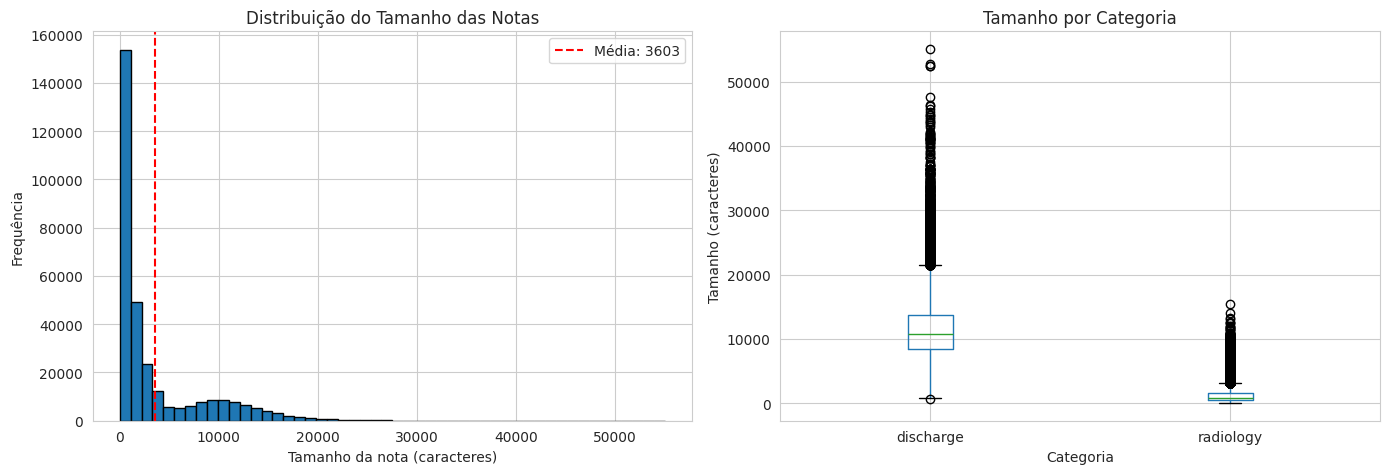

In [20]:
# Distribuição de tamanhos
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
notes['text_length'] = notes['text'].str.len()

# Histograma
notes['text_length'].hist(bins=50, ax=ax[0], edgecolor='black')
ax[0].set_xlabel('Tamanho da nota (caracteres)')
ax[0].set_ylabel('Frequência')
ax[0].set_title('Distribuição do Tamanho das Notas')
ax[0].axvline(stats['avg_text_length'], color='red', linestyle='--', label=f'Média: {stats["avg_text_length"]:.0f}')
ax[0].legend()

# Boxplot por categoria
notes.boxplot(column='text_length', by='note_category', ax=ax[1])
ax[1].set_xlabel('Categoria')
ax[1].set_ylabel('Tamanho (caracteres)')
ax[1].set_title('Tamanho por Categoria')
plt.suptitle('')

plt.tight_layout()
plt.show()

## 5. Pré-processamento de Texto

INFO:src.data.text_preprocessing:🧹 Pré-processando 315,202 notas...
INFO:src.data.text_preprocessing:✓ Notas válidas: 315,154/315,202



✓ Pré-processamento concluído
  - Notas válidas: 315,154/315,202
  - Redução média: 3.0%

📝 Exemplo de nota processada:
Original (10608 chars):
 
Name:  ___                     Unit No:   ___
 
Admission Date:  ___              Discharge Date:   ___
 
Date of Birth:  ___             Sex:   F
 
Service: MEDICINE
 
Allergies: 
Percocet / Vicodin
 
Attending: ___
 
Chief Complaint:
altered mental status
 
Major Surgical or Invasive Procedure:


Limpa (10287 chars):
Name: ___ Unit No: ___ Admission Date: ___ Discharge Date: ___ Date of Birth: ___ Sex: F Service: MEDICINE Allergies: Percocet / Vicodin Attending: ___ Chief Complaint: altered mental status Major Surgical or Invasive Procedure: none History of Present Illness: Mrs. ___ is a ___ female with HIV on H


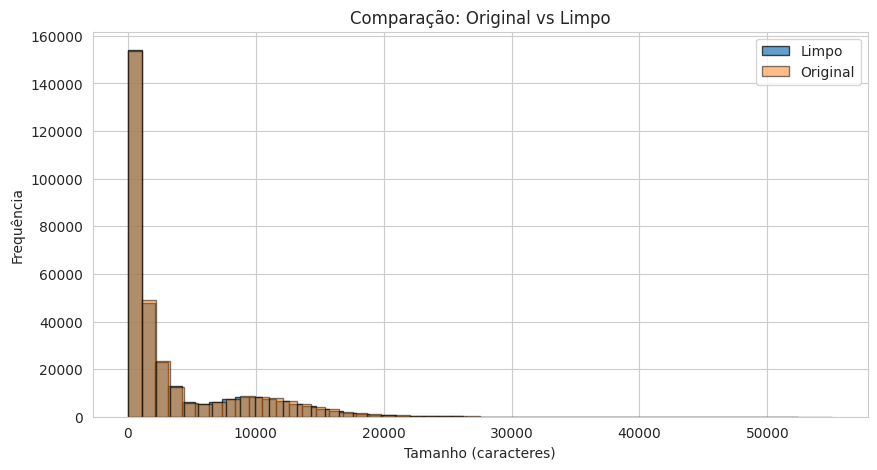

In [21]:
# Inicializar preprocessor
preprocessor = TextPreprocessor(config=text_config)

# Aplicar pré-processamento
notes_clean = preprocessor.preprocess_dataframe(notes, text_column='text')

print(f"\n✓ Pré-processamento concluído")
print(f"  - Notas válidas: {notes_clean['is_valid'].sum():,}/{len(notes_clean):,}")
print(f"  - Redução média: {((1 - notes_clean['cleaned_length'].mean() / notes_clean['original_length'].mean()) * 100):.1f}%")

# Exemplo de nota processada
sample_idx = notes_clean[notes_clean['is_valid']].iloc[0].name
print(f"\n📝 Exemplo de nota processada:")
print(f"Original ({notes_clean.loc[sample_idx, 'original_length']} chars):")
print(notes.loc[sample_idx, 'text'][:300])
print(f"\nLimpa ({notes_clean.loc[sample_idx, 'cleaned_length']} chars):")
print(notes_clean.loc[sample_idx, 'cleaned_text'][:300])

# Distribuição após limpeza
fig, ax = plt.subplots(figsize=(10, 5))
notes_clean[notes_clean['is_valid']]['cleaned_length'].hist(bins=50, ax=ax, edgecolor='black', alpha=0.7, label='Limpo')
notes_clean['original_length'].hist(bins=50, ax=ax, edgecolor='black', alpha=0.5, label='Original')
ax.set_xlabel('Tamanho (caracteres)')
ax.set_ylabel('Frequência')
ax.set_title('Comparação: Original vs Limpo')
ax.legend()
plt.show()

## 6. Filtro Temporal

In [16]:
edstays_time.columns

Index(['subject_id', 'hadm_id', 'intime', 'outtime'], dtype='object')

✓ Carregando edstays para filtro temporal...


INFO:src.data.notes_loader:⏱️ Aplicando filtro temporal nas notas...
INFO:src.data.notes_loader:  - Notas com hadm_id válido: 315,202
INFO:src.data.notes_loader:  - Notas após merge com ED stays: 313,133
INFO:src.data.notes_loader:  - Notas com timestamps válidos: 313,133
INFO:src.data.notes_loader:✓ Filtro temporal: 315,202 → 98,237 notas (31.2% mantidas)



✓ Filtro temporal aplicado
  - Antes: 315,202 notas
  - Depois: 98,237 notas
  - Mantidas: 31.2%


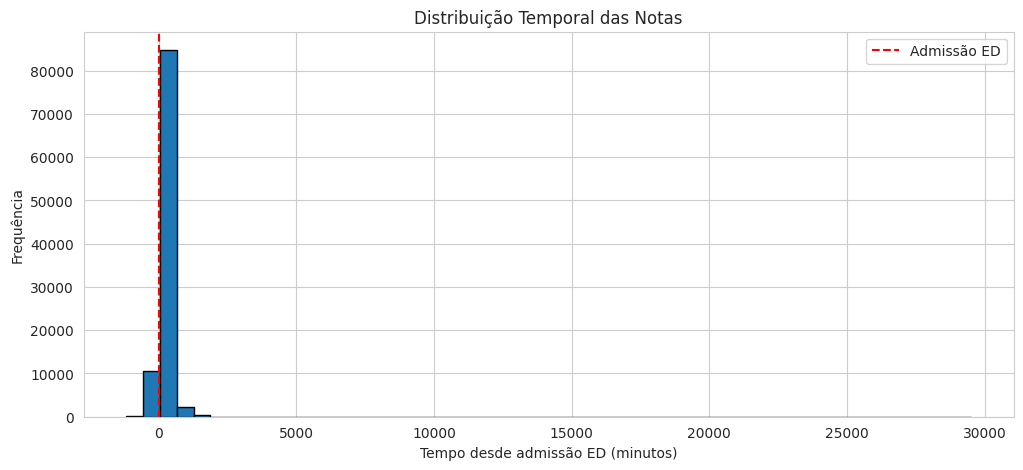

In [23]:
# Carregar ED stays para obter timestamps
# Precisamos de intime e outtime
edstays_file = DATA_ROOT / 'ed/edstays.csv'

if edstays_file.exists():
    print(f"✓ Carregando edstays para filtro temporal...")
    edstays_time = pd.read_csv(
        edstays_file,
        usecols=['subject_id', 'hadm_id', 'intime', 'outtime'],
        parse_dates=['intime', 'outtime']
    )
    
    # Aplicar filtro temporal
    notes_temporal = notes_loader.filter_temporal(
        notes_clean,
        edstays_time,
        time_buffer_hours=0  # Rigoroso: apenas notas DURANTE ED stay
    )
    
    print(f"\n✓ Filtro temporal aplicado")
    print(f"  - Antes: {len(notes_clean):,} notas")
    print(f"  - Depois: {len(notes_temporal):,} notas")
    print(f"  - Mantidas: {len(notes_temporal)/len(notes_clean)*100:.1f}%")
    
    # Distribuição temporal
    fig, ax = plt.subplots(figsize=(12, 5))
    notes_temporal['time_from_admission_min'].hist(bins=50, ax=ax, edgecolor='black')
    ax.set_xlabel('Tempo desde admissão ED (minutos)')
    ax.set_ylabel('Frequência')
    ax.set_title('Distribuição Temporal das Notas')
    ax.axvline(0, color='red', linestyle='--', label='Admissão ED')
    ax.legend()
    plt.show()
    
    # Usar notas com filtro temporal
    notes_final = notes_temporal
    
else:
    print(f"⚠️ edstays.csv não encontrado, pulando filtro temporal")
    notes_final = notes_clean

## 7. Integração Texto + Tabular

In [24]:
# Inicializar integrador
integrator = TextTabularIntegrator(strategy=FUSION_STRATEGY)

# Associar notas aos ED stays
# Estratégia: usar nota com maior prioridade (discharge > radiology)
df_integrated = integrator.associate_notes_to_stays(
    df_tabular,
    notes_final,
    strategy='priority'
)

print(f"\n✓ Integração concluída")
print(f"  - Total stays: {len(df_integrated):,}")

# Estatísticas da integração
integration_stats = integrator.get_statistics(df_integrated)
print(f"\n📊 Estatísticas da integração:")
print(f"  - Stays com texto: {integration_stats['with_text']:,} ({integration_stats['text_coverage']*100:.1f}%)")
print(f"  - Tamanho médio do texto: {integration_stats['avg_text_length']:.0f} chars")
print(f"  - Features tabulares: {integration_stats['tabular_features']}")

if 'by_category' in integration_stats:
    print(f"  - Por categoria: {integration_stats['by_category']}")


INFO:src.data.text_integration:🔗 Associando notas aos stays (strategy=priority)...
INFO:src.data.text_integration:✓ 60,172 stays com texto



✓ Integração concluída
  - Total stays: 189,158

📊 Estatísticas da integração:
  - Stays com texto: 60,172 (31.8%)
  - Tamanho médio do texto: 1494 chars
  - Features tabulares: 94
  - Por categoria: {'RR': 58387, 'DS': 1697, 'AR': 88}


In [25]:
df_integrated.columns

Index(['subject_id', 'hadm_id', 'stay_id', 'intime', 'outtime', 'gender_x',
       'race', 'arrival_transport', 'disposition', 'gender_y', 'anchor_age',
       'anchor_year', 'dod', 'gender', 'admittime', 'dischtime', 'deathtime',
       'hospital_expire_flag', 'admission_type', 'admission_location',
       'discharge_location', 'subject_id_triage', 'temperature', 'heartrate',
       'resprate', 'o2sat', 'sbp', 'dbp', 'pain', 'acuity', 'chiefcomplaint',
       'years_from_anchor', 'age_at_ed', 'triage_completeness', 'ed_los_hours',
       'lengthened_ed_stay', 'hospital_death', 'age_group', 'triage_age',
       'triage_gender_male', 'triage_gender_female', 'triage_heart_rate',
       'triage_respiratory_rate', 'triage_sbp', 'triage_dbp',
       'triage_temperature', 'triage_spo2', 'triage_acuity', 'triage_pain',
       'triage_chief_complaint', 'lab_BLOOD_GAS_value', 'lab_CARDIO_value',
       'lab_CBC_value', 'lab_CHEM_value', 'lab_COAG_value', 'lab_INFLAM_value',
       'lab_LACTATE_

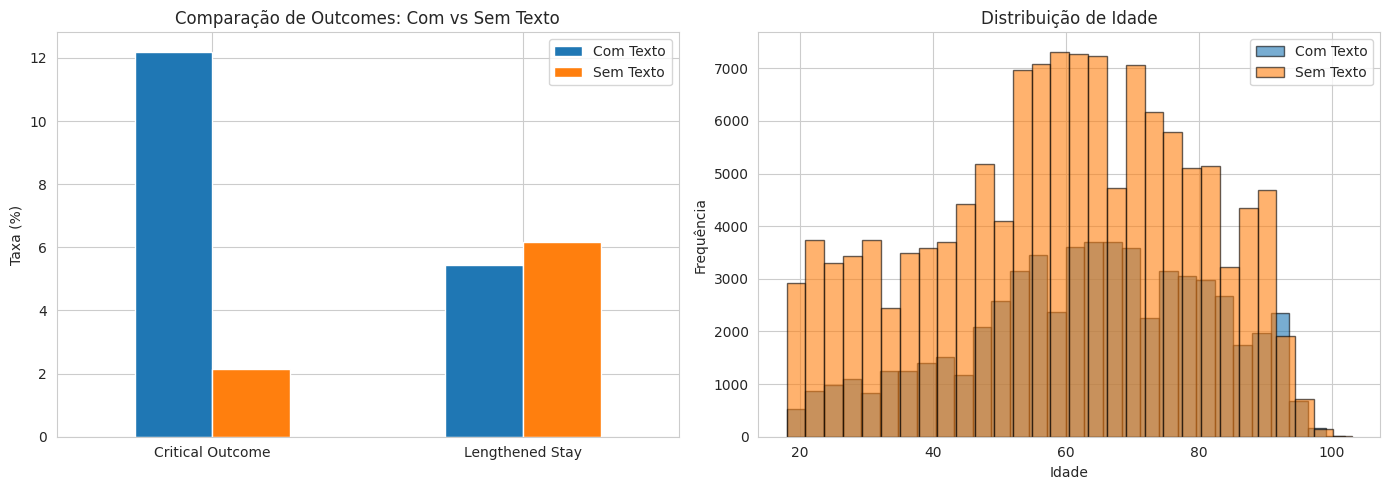

In [26]:

# Comparação: stays com vs sem texto
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Critical outcome
has_text = df_integrated['cleaned_text'].notna()
outcomes = pd.DataFrame({
    'Com Texto': [
        df_integrated[has_text]['critical_outcome'].mean() * 100,
        df_integrated[has_text]['lengthened_ed_stay'].mean() * 100
    ],
    'Sem Texto': [
        df_integrated[~has_text]['critical_outcome'].mean() * 100,
        df_integrated[~has_text]['lengthened_ed_stay'].mean() * 100
    ]
}, index=['Critical Outcome', 'Lengthened Stay'])

outcomes.plot(kind='bar', ax=axes[0], rot=0)
axes[0].set_ylabel('Taxa (%)')
axes[0].set_title('Comparação de Outcomes: Com vs Sem Texto')
axes[0].legend(title='')

# Distribuição de idade
df_integrated[has_text]['age_at_ed'].hist(bins=30, ax=axes[1], alpha=0.6, label='Com Texto', edgecolor='black')
df_integrated[~has_text]['age_at_ed'].hist(bins=30, ax=axes[1], alpha=0.6, label='Sem Texto', edgecolor='black')
axes[1].set_xlabel('Idade')
axes[1].set_ylabel('Frequência')
axes[1].set_title('Distribuição de Idade')
axes[1].legend()

plt.tight_layout()
plt.show()


## 8. Criar Dataset Multi-Modal

In [ ]:
# Criar dataset final
dataset = integrator.create_multimodal_dataset(
    df_integrated,
    text_column='cleaned_text',
    outcome_column='critical_outcome'
)

print(f"\n✅ Dataset multi-modal criado")
print(f"  - Shape: {dataset.shape}")
print(f"  - Colunas: {dataset.columns.tolist()}")

# Resumo
print(f"\n📋 Resumo do dataset:")
print(dataset.describe())

# Missing values
missing = dataset.isnull().sum()
if missing.sum() > 0:
    print(f"\n⚠️ Missing values:")
    print(missing[missing > 0])


## 9. Criar Splits Estratificados


In [ ]:
# Criar splits train/val/test
splits = create_stratified_splits(
    dataset,
    outcome_col='outcome',
    train_ratio=TRAIN_RATIO,
    val_ratio=VAL_RATIO,
    test_ratio=TEST_RATIO,
    random_state=RANDOM_STATE
)

# Validar distribuição
print(f"\n🔍 Validação dos splits:")
for split_name, split_df in splits.items():
    print(f"\n{split_name.upper()}:")
    print(f"  - Size: {len(split_df):,}")
    print(f"  - Outcome rate: {split_df['outcome'].mean()*100:.2f}%")
    print(f"  - Com texto: {split_df['has_text'].sum():,} ({split_df['has_text'].mean()*100:.1f}%)")

# Visualizar distribuição
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, (split_name, split_df) in enumerate(splits.items()):
    # Outcome por split
    outcome_counts = split_df['outcome'].value_counts()
    axes[idx].bar(outcome_counts.index, outcome_counts.values, edgecolor='black')
    axes[idx].set_title(f'{split_name.upper()}: Outcomes')
    axes[idx].set_xlabel('Outcome')
    axes[idx].set_ylabel('Count')
    axes[idx].set_xticks([0, 1])
    axes[idx].set_xticklabels(['Negative', 'Positive'])

plt.tight_layout()
plt.show()

## 10. Salvar Dados Processados


In [ ]:
# Salvar splits individuais
output_files = {}

for split_name, split_df in splits.items():
    output_file = PROCESSED_ROOT / f'multimodal_{split_name}.parquet'
    split_df.to_parquet(output_file, index=False)
    output_files[split_name] = output_file
    print(f"✓ Salvo: {output_file}")

# Salvar dataset completo
full_output = PROCESSED_ROOT / 'multimodal_full.parquet'
dataset.to_parquet(full_output, index=False)
output_files['full'] = full_output
print(f"✓ Salvo: {full_output}")

# Salvar metadados
metadata = {
    'created_at': datetime.now().isoformat(),
    'text_config': {
        'max_tokens': int(text_config.max_tokens_per_segment),
        'min_length': int(text_config.min_text_length)
    },
    'fusion_strategy': FUSION_STRATEGY.value,
    'splits': {
        'train': int(len(splits['train'])),
        'val': int(len(splits['val'])),
        'test': int(len(splits['test']))
    },
    'outcomes': {
        'critical_outcome': int(dataset['outcome'].sum()),
        'rate': float(dataset['outcome'].mean())
    },
    'text_coverage': float(dataset['has_text'].mean()),
    'files': {k: str(v) for k, v in output_files.items()}
}

import json
metadata_file = PROCESSED_ROOT / 'multimodal_metadata.json'
with open(metadata_file, 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"✓ Salvo: {metadata_file}")

print(f"\n✅ Pipeline concluído!")
print(f"📁 Arquivos salvos em: {PROCESSED_ROOT}")